In [ ]:
# !!!!!!!!!! TO-DO +++++++
# 1) scale hh and qcd inputs coherently --> thanks colby
# 2) make 2D latent plots?
# 3) consider whittling down hard-to-model inputs e.g. nJets
# 3) ...
# N) make benchmark BSM -> 4b model for comparison

In [99]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization
from keras.regularizers import l2, l1
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras as keras
import seaborn as sns

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [6]:
import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

In [7]:
# *** 1. Import data and check stuff
testingFraction = 0.3

In [8]:
# ** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

Dihiggs file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_500kEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv
QCD file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_2MEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv


In [75]:
# ** B. Make testing and training samples
variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'jet2_eta', 'jet3_eta', 
             'nJets', 'jet3_pz', 'jet4_eta', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'scalarHT', 'deltaPhi(h1, h2)', 
             'deltaPhi(h1 jets)', 'jet4_pt', 'jet2_pt', 'jet1_pz', 'jet1_pt', 'jet1_mass']

#variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'jet2_eta', 'jet3_eta', 
#             'nJets', 'jet3_pz', 'jet4_eta', 'h1_mass']
data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, 
                                                                                         variables, testingFraction)

#data_hh_train, data_hh_test, labels_hh_train, labels_hh_test = makeTestTrainSamplesWithUserVariables(hh_raw[hh_raw.isSignal==1], 
#                                                                             qcd_raw[qcd_raw.isSignal==1], 
#                                                                             variables, testingFraction)

# ** C. Apply normalization to make 0mean/1sigma data inputs
sc = StandardScaler()
data_train__norm = sc.fit_transform(data_train)
data_test__norm = sc.fit_transform(data_test)


# ** D. Split into qcd (training) and hh ("anomaly")
# add labels
data_train__norm = np.concatenate((data_train__norm, labels_train), 1)
data_test__norm  = np.concatenate((data_test__norm, labels_test), 1)

# make qcd training set and separated testing sets
data_train__norm    = data_train__norm[data_train__norm[:,-1]==0] # training with qcd only
data_hh_test__norm  = data_test__norm[data_test__norm[:,-1]==1] # testing with dihiggs only
data_qcd_test__norm = data_test__norm[data_test__norm[:,-1]==0] # testing with qcd only

# drop 'isSignal' from sets
data_train__norm    = np.delete(data_train__norm, -1, 1)
data_test__norm     = np.delete(data_test__norm, -1, 1)
data_qcd_test__norm = np.delete(data_qcd_test__norm, -1, 1)
data_hh_test__norm  = np.delete(data_hh_test__norm, -1, 1)

#print(len(data_train__norm[0]), len(data_qcd_test__norm[0]), len(data_hh_test__norm[0]), len(data_train.columns))

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [137]:
# *** 2. Setup auto-encoder network structure
def newAutoEncoder( _compiler, _data_columns, _encodingDimensions=21, _loss='binary_crossentropy'):
    """function so you don't have to re-run everything everytime"""

    # Size of our encoded representataion -> compression of factor _encodingDimensions / len(data_columns)
    print(_data_columns.shape)
    
    # size of hidden layer between input/output and latent
    _intermediaryDimensions = _data_columns.shape[0]*2
    
    # Input placeholder
    _input_img = Input(shape = _data_columns.shape )
    # "encoded" is the encoded representation of the input
    #_encoded = Dense(_encodingDimensions, activation='relu')(_input_img) # relu ORIGINAL
    
    _encoded = Dense(_intermediaryDimensions, activation='relu')(_input_img) # relu ORIGINAL
    _encoded = Dropout(0.1)(_encoded) # relu ORIGINAL

    _encoded = Dense(_encodingDimensions, activation='tanh')(_encoded) # relu ORIGINAL
    
   
    # "decoded" is the lossy reconstruction of the input
    #_decoded = Dense( _data_columns.shape[0], activation='linear')(_encoded) # sigmoid # ORIGINAL
    
    _decoded = Dense( _intermediaryDimensions, activation='relu')(_encoded) # sigmoid
    _decoded = Dense( _data_columns.shape[0], activation='linear')(_decoded) # sigmoid

    # this model maps an input to its reconstruction
    _autoencoder = Model(_input_img, _decoded)

    # this model maps an input to its encoded representation
    _encoder = Model(_input_img, _encoded)

    """
    # create a placeholder for an encoded (32-dimensional) input
    _encoded_input = Input(shape=(_encodingDimensions,))
    # retrieve the last layer of the autoencoder model
    _decoder_layer = _autoencoder.layers[-1]
    # create the decoder model
    #_decoder = Model(_encoded_input, _decoder_layer(_encoded_input)) # ORIGINAL
    _decoder = Model(_intermediaryDimensions, _decoder_layer(_encoded_input))
    """
    
    _loss = 'mse'
    _autoencoder.compile(optimizer=_compiler, loss=_loss, metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    
    #return _autoencoder, _encoder, _decoder
    return _autoencoder, _encoder


# compile the model
#_copiler = 'adadelta'
_compiler = 'adam'
encodedDimensions = 5
#encodedDimensions = data_train.columns.shape[0] # "identity" encoder
autoencoder, encoder = newAutoEncoder( _compiler, data_train.columns, 
                                      _encodingDimensions=encodedDimensions)

autoencoder.summary()

(21,)
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 42)                924       
_________________________________________________________________
dropout_5 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 215       
_________________________________________________________________
dense_35 (Dense)             (None, 42)                252       
_________________________________________________________________
dense_36 (Dense)             (None, 21)                903       
Total params: 2,294
Trainable params: 2,294
Non-trainable params: 0
__________________________________________________

In [141]:
# *** 3. Train the model
history = autoencoder.fit(data_train__norm, data_train__norm,
                          #data_train, data_train,
                          epochs=250,
                          batch_size=512,
                          shuffle=True,
                          validation_data=(data_test__norm, data_test__norm))

Train on 81597 samples, validate on 58608 samples
Epoch 1/250
81597/81597 [==============================] - 7s 85us/step - loss: 0.3589 - accuracy: 0.3742 - auc: 0.0000e+00 - val_loss: 0.3447 - val_accuracy: 0.3582 - val_auc: 0.0000e+00
Epoch 2/250
81597/81597 [==============================] - 7s 81us/step - loss: 0.3566 - accuracy: 0.3794 - auc: 0.0000e+00 - val_loss: 0.3428 - val_accuracy: 0.3602 - val_auc: 0.0000e+00
Epoch 3/250
81597/81597 [==============================] - 7s 80us/step - loss: 0.3548 - accuracy: 0.3815 - auc: 0.0000e+00 - val_loss: 0.3405 - val_accuracy: 0.3650 - val_auc: 0.0000e+00
Epoch 4/250
81597/81597 [==============================] - 6s 79us/step - loss: 0.3530 - accuracy: 0.3858 - auc: 0.0000e+00 - val_loss: 0.3386 - val_accuracy: 0.3682 - val_auc: 0.0000e+00
Epoch 5/250
81597/81597 [==============================] - 6s 75us/step - loss: 0.3511 - accuracy: 0.3891 - auc: 0.0000e+00 - val_loss: 0.3360 - val_accuracy: 0.3711 - val_auc: 0.0000e+00
Epoch 6/25

81597/81597 [==============================] - 8s 97us/step - loss: 0.3208 - accuracy: 0.4186 - auc: 0.0000e+00 - val_loss: 0.3070 - val_accuracy: 0.4089 - val_auc: 0.0000e+00
Epoch 45/250
81597/81597 [==============================] - 6s 77us/step - loss: 0.3200 - accuracy: 0.4189 - auc: 0.0000e+00 - val_loss: 0.3073 - val_accuracy: 0.4107 - val_auc: 0.0000e+00
Epoch 46/250
81597/81597 [==============================] - 6s 77us/step - loss: 0.3197 - accuracy: 0.4181 - auc: 0.0000e+00 - val_loss: 0.3065 - val_accuracy: 0.4098 - val_auc: 0.0000e+00
Epoch 47/250
81597/81597 [==============================] - 6s 75us/step - loss: 0.3192 - accuracy: 0.4202 - auc: 0.0000e+00 - val_loss: 0.3060 - val_accuracy: 0.4099 - val_auc: 0.0000e+00
Epoch 48/250
81597/81597 [==============================] - 6s 75us/step - loss: 0.3187 - accuracy: 0.4188 - auc: 0.0000e+00 - val_loss: 0.3064 - val_accuracy: 0.4105 - val_auc: 0.0000e+00
Epoch 49/250
81597/81597 [==============================] - 6s 75us/

81597/81597 [==============================] - 6s 75us/step - loss: 0.3077 - accuracy: 0.4223 - auc: 0.0000e+00 - val_loss: 0.2968 - val_accuracy: 0.4149 - val_auc: 0.0000e+00
Epoch 88/250
81597/81597 [==============================] - 6s 74us/step - loss: 0.3074 - accuracy: 0.4220 - auc: 0.0000e+00 - val_loss: 0.2971 - val_accuracy: 0.4150 - val_auc: 0.0000e+00
Epoch 89/250
81597/81597 [==============================] - 6s 74us/step - loss: 0.3075 - accuracy: 0.4204 - auc: 0.0000e+00 - val_loss: 0.2966 - val_accuracy: 0.4157 - val_auc: 0.0000e+00
Epoch 90/250
81597/81597 [==============================] - 6s 74us/step - loss: 0.3068 - accuracy: 0.4221 - auc: 0.0000e+00 - val_loss: 0.2953 - val_accuracy: 0.4138 - val_auc: 0.0000e+00
Epoch 91/250
81597/81597 [==============================] - 6s 75us/step - loss: 0.3069 - accuracy: 0.4216 - auc: 0.0000e+00 - val_loss: 0.2956 - val_accuracy: 0.4115 - val_auc: 0.0000e+00
Epoch 92/250
81597/81597 [==============================] - 6s 76us/

81597/81597 [==============================] - 6s 79us/step - loss: 0.3003 - accuracy: 0.4287 - auc: 0.0000e+00 - val_loss: 0.2906 - val_accuracy: 0.4191 - val_auc: 0.0000e+00
Epoch 131/250
81597/81597 [==============================] - 6s 79us/step - loss: 0.3004 - accuracy: 0.4281 - auc: 0.0000e+00 - val_loss: 0.2918 - val_accuracy: 0.4186 - val_auc: 0.0000e+00
Epoch 132/250
81597/81597 [==============================] - 6s 77us/step - loss: 0.3007 - accuracy: 0.4271 - auc: 0.0000e+00 - val_loss: 0.2912 - val_accuracy: 0.4180 - val_auc: 0.0000e+00
Epoch 133/250
81597/81597 [==============================] - 6s 77us/step - loss: 0.3001 - accuracy: 0.4277 - auc: 0.0000e+00 - val_loss: 0.2914 - val_accuracy: 0.4189 - val_auc: 0.0000e+00
Epoch 134/250
81597/81597 [==============================] - 6s 78us/step - loss: 0.2998 - accuracy: 0.4286 - auc: 0.0000e+00 - val_loss: 0.2908 - val_accuracy: 0.4178 - val_auc: 0.0000e+00
Epoch 135/250
81597/81597 [==============================] - 6s 

81597/81597 [==============================] - 6s 73us/step - loss: 0.2962 - accuracy: 0.4365 - auc: 0.0000e+00 - val_loss: 0.2867 - val_accuracy: 0.4294 - val_auc: 0.0000e+00
Epoch 174/250
81597/81597 [==============================] - 6s 73us/step - loss: 0.2956 - accuracy: 0.4345 - auc: 0.0000e+00 - val_loss: 0.2868 - val_accuracy: 0.4320 - val_auc: 0.0000e+00
Epoch 175/250
81597/81597 [==============================] - 6s 72us/step - loss: 0.2955 - accuracy: 0.4363 - auc: 0.0000e+00 - val_loss: 0.2864 - val_accuracy: 0.4309 - val_auc: 0.0000e+00
Epoch 176/250
81597/81597 [==============================] - 6s 72us/step - loss: 0.2960 - accuracy: 0.4348 - auc: 0.0000e+00 - val_loss: 0.2861 - val_accuracy: 0.4305 - val_auc: 0.0000e+00
Epoch 177/250
81597/81597 [==============================] - 6s 72us/step - loss: 0.2958 - accuracy: 0.4347 - auc: 0.0000e+00 - val_loss: 0.2857 - val_accuracy: 0.4307 - val_auc: 0.0000e+00
Epoch 178/250
81597/81597 [==============================] - 6s 

81597/81597 [==============================] - 6s 77us/step - loss: 0.2931 - accuracy: 0.4425 - auc: 0.0000e+00 - val_loss: 0.2841 - val_accuracy: 0.4390 - val_auc: 0.0000e+00
Epoch 217/250
81597/81597 [==============================] - 6s 79us/step - loss: 0.2931 - accuracy: 0.4414 - auc: 0.0000e+00 - val_loss: 0.2839 - val_accuracy: 0.4404 - val_auc: 0.0000e+00
Epoch 218/250
81597/81597 [==============================] - 7s 81us/step - loss: 0.2931 - accuracy: 0.4424 - auc: 0.0000e+00 - val_loss: 0.2843 - val_accuracy: 0.4399 - val_auc: 0.0000e+00
Epoch 219/250
81597/81597 [==============================] - 7s 80us/step - loss: 0.2930 - accuracy: 0.4432 - auc: 0.0000e+00 - val_loss: 0.2848 - val_accuracy: 0.4394 - val_auc: 0.0000e+00
Epoch 220/250
81597/81597 [==============================] - 6s 73us/step - loss: 0.2930 - accuracy: 0.4409 - auc: 0.0000e+00 - val_loss: 0.2834 - val_accuracy: 0.4399 - val_auc: 0.0000e+00
Epoch 221/250
81597/81597 [==============================] - 6s 

In [142]:
# *** 4. Evaluate results
# encode and decode some events ~~~! note that tests taken from ... test set
encoded_imgs = encoder.predict(data_qcd_test__norm)
encoded_hh_imgs = encoder.predict(data_hh_test__norm)

#decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = autoencoder.predict(data_qcd_test__norm)
decoded_hh_imgs = autoencoder.predict(data_hh_test__norm)

dict_keys(['val_loss', 'val_accuracy', 'val_auc', 'loss', 'accuracy', 'auc'])


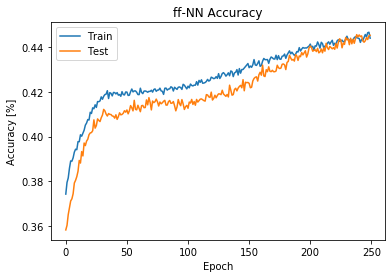

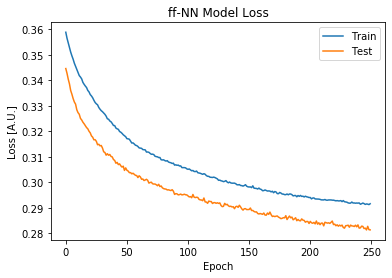

In [143]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ff-NN Accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ff-NN Model Loss')
plt.ylabel('Loss [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()



(array([1.000e+00, 1.200e+01, 2.800e+02, 1.110e+03, 2.024e+03, 2.781e+03,
        1.968e+03, 1.241e+03, 9.320e+02, 8.030e+02, 6.940e+02, 6.930e+02,
        8.750e+02, 1.198e+03, 3.125e+03, 6.540e+03, 5.383e+03, 3.090e+03,
        1.386e+03, 5.440e+02, 1.570e+02, 3.700e+01, 5.000e+00, 2.000e+00,
        3.000e+00]),
 array([-2.266602  , -2.0709207 , -1.8752391 , -1.6795578 , -1.4838763 ,
        -1.2881949 , -1.0925134 , -0.89683205, -0.7011506 , -0.5054692 ,
        -0.30978775, -0.11410632,  0.08157511,  0.27725655,  0.47293797,
         0.6686194 ,  0.86430085,  1.0599823 ,  1.2556636 ,  1.4513451 ,
         1.6470265 ,  1.842708  ,  2.0383894 ,  2.2340708 ,  2.4297523 ,
         2.6254337 ], dtype=float32),
 <a list of 25 Patch objects>)

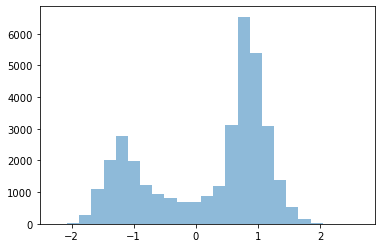

In [81]:
#plt.hist(encoded_imgs[:,5], bins=25, alpha=0.5)
#plt.hist(decoded_imgs[:,4], bins=25, alpha=0.5)

#plt.hist(data_train__norm[:,0], bins = 25, alpha=0.5)
plt.hist(decoded_imgs[:,1], bins=25, alpha=0.5)


In [82]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                1100      
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 255       
_________________________________________________________________
dense_15 (Dense)             (None, 50)                300       
_________________________________________________________________
dense_16 (Dense)             (None, 21)                1071      
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


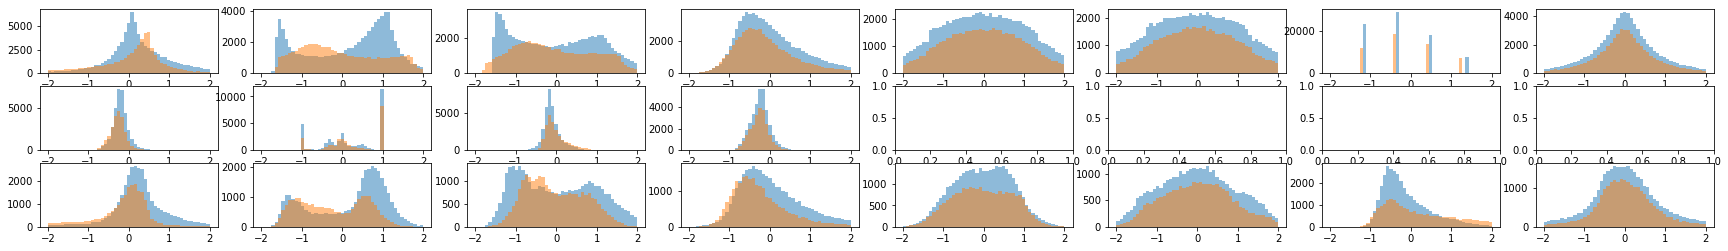

In [144]:
n = 8  # how many digits we will display
#nBins = 25
#nBins = np.linspace(min(data_train__norm[:,0]), max(data_train__norm[:,0]), 25)
nBins = np.linspace(-2, 2, 50)
nBins2 = np.linspace(-2, 2, 50)
plt.figure(figsize=(30, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.hist(data_train__norm[:,i], bins=nBins, alpha=0.5)
    plt.hist(data_hh_train__norm[:,i], bins=nBins, alpha=0.5)
   
    # display latent
    ax = plt.subplot(3, n, i + 1 + n)
    if i < (encodedDimensions-1) :
        plt.hist(encoded_imgs[:, i], bins=nBins2, alpha=0.5)
        plt.hist(encoded_hh_imgs[:, i], bins=nBins2, alpha=0.5)
        #plt.hist(encoded_imgs[:,min(i, encodedDimensions-1)], bins=nBins2, alpha=0.5)
        #plt.hist(encoded_hh_imgs[:,min(i, encodedDimensions-1)], bins=nBins2, alpha=0.5)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.hist(decoded_imgs[:,i], bins=nBins, alpha=0.5)
    plt.hist(decoded_hh_imgs[:,i], bins=nBins, alpha=0.5)

    
plt.show()

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  857., 1385., 1311., 1342., 1244., 1367.,
        1546., 1840., 2168., 2607., 2930., 2733., 1172.,  541.,  289.,
         154.,   81.,   53.,   41.,   23.,   17.,    7.,    6.,    6.,
           4.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([-2.        , -1.91836735, -1.83673469, -1.75510204, -1.67346939,
        -1.59183673, -1.51020408, -1.42857143, -1.34693878, -1.26530612,
        -1.18367347, -1.10204082, -1.02040816, -0.93877551, -0.85714286,
        -0.7755102 , -0.69387755, -0.6122449 , -0.53061224, -0.44897959,
        -0.36734694, -0.28571429, -0.20408163, -0.12244898, -0.04081633,
         0.04081633,  0.12244898,  0.20408163,  0.28571429,  0.36734694,
         0.44897959,  0.53061224,  0.6122449 ,  0.69387755,  0.7755102 ,
         0.85714286,  0.93877551,  1.02040816,  1.10204082,  1.18367347,
         1.26530612,  1

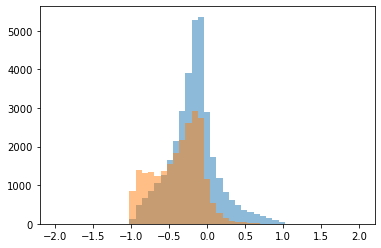

In [96]:
plt.hist(encoded_imgs[:,0], bins=nBins2, alpha=0.5)
plt.hist(encoded_hh_imgs[:,0], bins=nBins2, alpha=0.5)


In [145]:
def jointPlots( _hh_imgs, _qcd_imgs, _latentVar1, _latentVar2):
    sns.jointplot(x=_hh_imgs[:,_latentVar1], y=_hh_imgs[:,_latentVar2], kind='hex')
    plt.show()

    sns.jointplot(x=_qcd_imgs[:,_latentVar1], y=_qcd_imgs[:,_latentVar2], kind='hex')
    plt.show()

#plt.scatter(encoded_hh_imgs[:,0], encoded_hh_imgs[:,1])
#sns.jointplot(x=encoded_hh_imgs[:,0], y=encoded_hh_imgs[:,1], kind='hex')
#plt.show()
#sns.jointplot(x=encoded_hh_imgs[:,0], y=encoded_hh_imgs[:,2], kind='hex')
#plt.show()
#sns.jointplot(x=encoded_hh_imgs[:,0], y=encoded_hh_imgs[:,3], kind='hex')
#plt.show()
#sns.jointplot(x=encoded_hh_imgs[:,0], y=encoded_hh_imgs[:,4], kind='hex')
#plt.show()

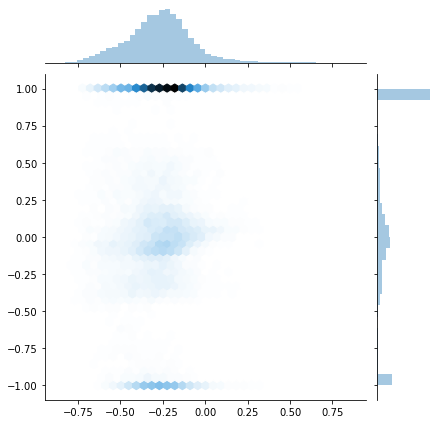

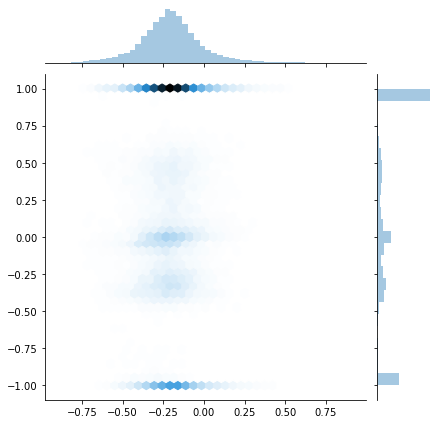

In [146]:
jointPlots( encoded_hh_imgs, encoded_imgs, 0, 1)

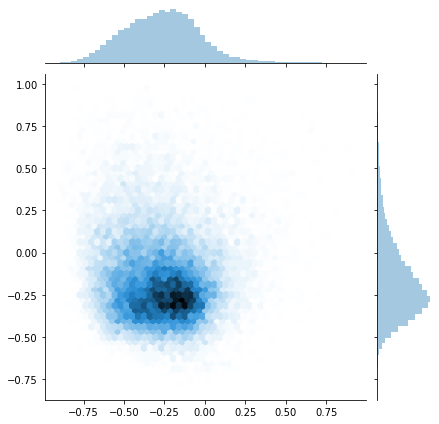

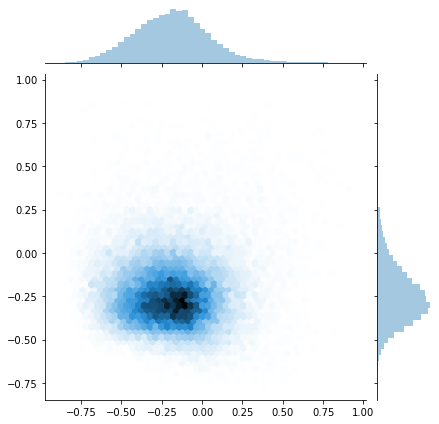

In [134]:
jointPlots( encoded_hh_imgs, encoded_imgs, 0, 2)


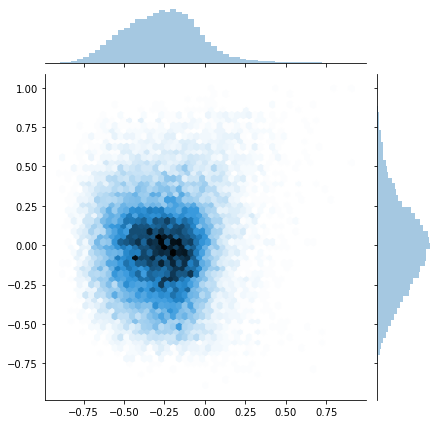

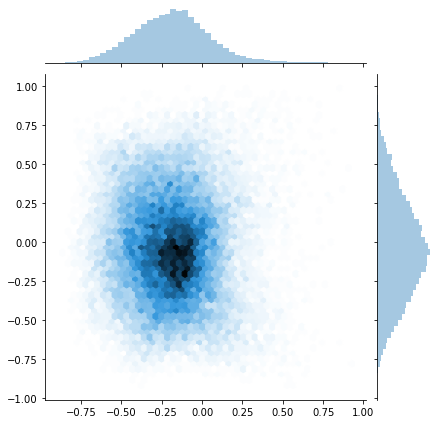

In [135]:
jointPlots( encoded_hh_imgs, encoded_imgs, 0, 3)


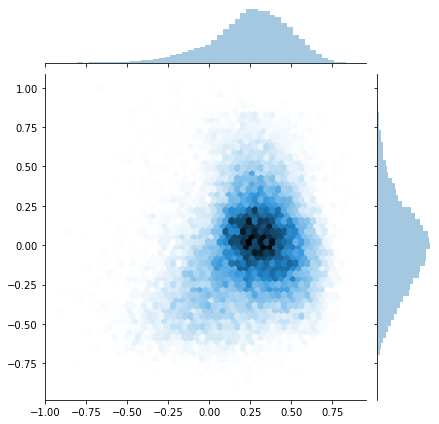

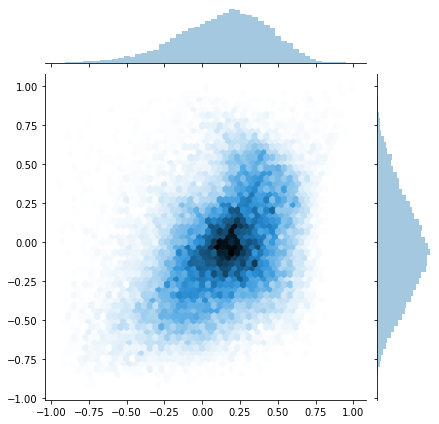

In [136]:
jointPlots( encoded_hh_imgs, encoded_imgs, 1, 3)
